# Reinforcement Learning for Meal Planning based on Meeting a Set Budget and Personal Preferences

## Aim

When food shopping, there are many different products for the same ingredient to choose from in supermarkets. Some are less expensive, others are of higher quality. I would like to create a model that, for the required ingredients, can select the optimal products required to make a meal that is both:

1. Within my budget

2. Meets my personal preferences

To do this, I will first build a very simple model that can recommend the products that are below my budgets before introducing my preferences.

The reason we use a model is so that we could, in theory, scale the problem to consider more and more ingredients and products that would cause the problemt to then be beyond the possibility of any mental calculations.

## Method

To achieve this, I will be bulding a simple reinforcement learning model and use Montel Carlo learning to find the optimal combination of products.

First, let us formally define the parts of our model as a Markov Decision Process:

- We have a finite number of ingredients required to make any meal and are considered to be our **States**
- There are the finite possible products for each ingredient and are therefore the **Actions of each state**
- Our preferences become the **Individual Rewards** for selecting each product, we will cover this in more detail later

Monte Carlo learning takes the combined the quality of each step towards reaching an end goal and requires that, in order to assess the quality of any step, we must wait and see the outcome of the whole combination. 

Monte Carlo is often avoided due to the time required to go through the whole process before being able to learn. However, in our problem it is required as our final check when establishing whether the combination of products selected is good or bad is to add up the real cost of those selected and check whether or not this is below or above our budget. Futhermore, at least at this stage, we will not be considering more than a few ingredients and so the time taken is not significant in this regard.


## Sample Data

For this demonstration, I have created some sample data for a meal where we have 4 ingredients and 9 products, as shown in the digram below. 

We need to select one product for each ingredient in the meal.

This means we have 2 x 2 x 2 x 3 = 24 possible selections of products for the 4 ingredients.

I have also included the real cost for each product and V_0. 

V_0 is simply the initial quality of each product to meet our requirements and we set this to 0 for each.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
#data = pd.read_csv('C:\\Users\\kr015\\Documents\\Machine Learning\Meal Plan\\Final\\SampleData.csv')
data = pd.read_csv("/content/drive/MyDrive/ML_DL_STUDY/2월 4주차/SampleData.csv")

In [3]:
data

,Ingredient,Product,QMerged_label,Real_Cost,V_0
0,1,1,11,10,0
1,1,2,12,6,0
2,2,1,21,8,0
3,2,2,22,11,0
4,3,1,31,3,0
5,3,2,32,7,0
6,4,1,41,8,0
7,4,2,42,5,0
8,4,3,43,1,0


## Applying the Model in Theory

For now, I will not introduce any individual rewards for the procuts. Intead, I will simply focus on whether the combination of products selected is below our budget or not. This outcome is defined as the **Terminal Reward** of our problem.

For example, say we have a budget of £30, then the choice:

$$a1 \rightarrow b1 \rightarrow c1 \rightarrow d1$$
    
Then the real cost of this selection is:

$$£10 + £8 + £3 + £8 = £29 < £30$$

And therefore, our terminal reward is:

$$R_T = +1$$
    
Whereas, 

$$a2 \rightarrow b2 \rightarrow c2 \rightarrow d1$$
    
Then the real cost of this selection is:

$$£6 + £11 + £7 + £8 = £32 > £30$$

And therefore, our terminal reward is:

$$R_T = -1$$
    

For now, we are simply telling our model whether the choice is good or bad and will observe what this does to the results.

### Model Learning

So how does our model actually learn? In short, we get our model to try out lots of combinations of proucts and at the end of each tell it whether its choice was good or bad. Over time, it will recognise that some products generally lead to getting a good outcome while others do not.

What we end up creating are values for how good each product is, denoted V(a). We have already introduced the initial V(a) for each product but how do we reach go from these initial values to actually being able to make a decision?

For this, we need an **Update Rule**. This tells the model, after each time it has presented its choice of products and we have told it whether it's selection is good or bad, how to add this to our initial values. 

Our update rule is as follows:
    
$$V(a) \leftarrow V(a) + \alpha*(G - V(a))$$
    
This may look unusual at first but in words we are simply updating the value of any action, V(a), by an amount that is either a little more if the outcome was good or a little less if the outcome was bad. 


G is the **Return** and is simply to total reward obtained. Currently in our example, this is simply the terminal reward (+1 or -1 accordingly). We will reintroduce this later when we include individual product rewards.

Alpha, $\alpha$, is the **Learning Rate** and we will demonstrate how this effects the results more later but just for now, the simple explination is: "The learning rate determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing, while a factor of 1 makes the agent consider only the most recent information." (https://en.wikipedia.org/wiki/Q-learning)

### Small Demo of Updating Values

So how do we actually use this with our model?

Let us start with a table that has each product and its initial V_0(a):

|Product|V_0(a)|
|:-----:|:----:|
|   a1  |   0  |
|   a2  |   0  |
|   b1  |   0  |
|   b2  |   0  |
|   c1  |   0  |
|   c2  |   0  |
|   d1  |   0  |
|   d2  |   0  |
|   d3  |   0  |

---
We now pick a random selection of products, each cobination is known as an **episode**. We also set $\alpha = 0.5$ for now just for simpicity in the calculations.

e.g.

$$a1 \rightarrow b1 \rightarrow c1 \rightarrow d1$$ 

Provides:
  
$$Total Cost = £29 < £30$$

Therefore:
    
$$R_T = +1$$
    


Now applying our update rule to a1:

$$V_1(a1) <- V_0(a1) + \alpha*( G - V_0(a1))$$
    
$$\implies V_1(a1) <- 0 + 0.5*( 1 - 0) = 0.5$$


Therefore, all actions that lead to this positive outcome are updated as well to produced the following table with V1(a):

|Product|V_0(a)|V_1(a)|
|:-----:|:----:|:----:|
|   a1  |   0  |  0.5 |
|   a2  |   0  |   0  |
|   b1  |   0  |  0.5 |
|   b2  |   0  |   0  |
|   c1  |   0  |  0.5 |
|   c2  |   0  |   0  |
|   d1  |   0  |  0.5 |
|   d2  |   0  |   0  |
|   d3  |   0  |   0  |

---
So let us pick another random episode:

$$a1 \rightarrow b2 \rightarrow c2 \rightarrow d1$$

Provides:
  
$$Total Cost = £36 > £30$$

Therefore:
    
$$R_T = -1$$
    


Now applying our update rule to a1:



$$V_2(a1) \leftarrow V_1(a1) + \alpha * ( G - V_1(a1))$$

  
$$\implies V_2(a1) \leftarrow 0.5 + 0.5*( -1 - 0.5) = 0.5 - 0.75$$


$$\implies V_2(a1) \leftarrow -0.25$$



and likewise for d1.

Whereas the updated value for b2 is:

$$V_2(b2) \leftarrow V_1(b2) + \alpha*( G - V_1(b2))$$
    
$$\implies V_2(b2) \leftarrow 0 + 0.5*( -1 - 0) = -0.5$$
    
and likewise for c2.


Therefore, we can add V2(a) to our table:

|Product|V_0(a)|V_1(a)|V_2(a)|
|:-----:|:----:|:----:|:----:|
|   a1  |   0  |  0.5 | -0.25|
|   a2  |   0  |   0  |   0  |
|   b1  |   0  |  0.5 | 0.5  |
|   b2  |   0  |   0  | -0.5 |
|   c1  |   0  |  0.5 | 0.5  |
|   c2  |   0  |   0  | -0.5 |
|   d1  |   0  |  0.5 | -0.25|
|   d2  |   0  |   0  |   0  |
|   d3  |   0  |   0  |   0  |




## Action Selection

You may have noticed in the demo, I have simply randomly selected the products in each episode. We could do this but using a completely random selection process may mean that some actions are not selected often enough to know whether they are good or bad.

Similarly, if we went to other way and decided to select the products greedily, i.e. to ones that currently have the best value, we may miss one that is in fact better but never given a chance. For example, if we chose the best actions from V2(a) we would get a2, b1, c1 and d2 or d3 which both provide a positive terminal reward therefore, if we used a purely greedy selection process, we would never consider any other products as these continue to provide a positiv outcome. 

Instead, we implement **epsilon-greedy** action selection where we randomly select products with probablity $\epsilon$, and greedily select products with probability $1-\epsilon$ where:


$$0 \leq  \epsilon \leq  1$$
    
This means that we are going reach the optimal choice of products quickly as we continue to test whether the 'good' products are in fact optimal but also leaves room for us to also explore other products occasionally just to make sure they aren't as good as our current choice. 


# Building and Applying our Model

We are now ready to build a simple model as shown in the MCModelv1 function below.

Although this seems complex, I have done nothing more than apply the methods previously discussed in such a way that we can vary the inputs and still obtain reqults. Admittedly, this was my first attempt at doing this and so my coding may not be perfectly written but should be sufficient for our requirements. 


To calculate the terminal reward, we currently use the following condition to check if the total cost is less or more than our budget:

    if(budget >= episode2['Real_Cost'].sum()):
        Return = 1  
    else:
        Return = -1

In [4]:
def MCModelv1(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1  
        else:
            Return = -1 
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)




In [5]:
alpha = 0.1
num_episodes = 100
epsilon = 0.5
budget = 30

# Currently not using a reward
reward = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl = MCModelv1(data=data, alpha = alpha, e = num_episodes,epsilon = epsilon, budget = budget, reward = reward)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.7630953788757324 seconds ---


In our function, we have 6 outputs from the model.

- Mdl[0]: Returns the Sum of all V(a) for each episode

- Mdl[1]: Returns to Sum of V(a) for the cheapest products, possible to define due to the simplicity of our sample data

- Mdl[2]: Returns the Sum of V(a) for the non-cheapest products

- Mdl[3]: Returns the optimal actions of the final episode

- Mdl[4]: Returns the data table with the final V(a) added for each product

- Mdl[5]: Shows the optimal action at each epsiode

There is a lot to take away from these so let us go through each and establish what we can learn to improve our model.

#### Optimal actions of final episode

First, lets see what the model suggest we should select. In this run it suggests actions, or products, that have a total cost below budget which is good.

However, there is still more that we can check to help us understand what is going on.


First, we can plot the total V for all actions and we see that this is converging which is ideal. We want our model to converge so that as we try more episodes we are 'zoning-in' on the optimal choice of products. The reason the output converges is because we are reducing the amount it learns each time by a factor of $\alpha$, in this case 0.5. We will show later what happens if we vary this or don't apply this at all.

We have also plotted the sum of V for the produts we know are cheapest, based on being able to assess the small sample size, and the others seperately. Again, both are converging positively although the cheaper products appear to have slightly higher values.




In [11]:
print(Mdl[3])

Mdl[4]

Ingredient
1    2
2    1
3    1
4    2
Name: Product, dtype: int64


,Ingredient,Product,QMerged_label,Real_Cost,V_0,V
0,1,1,11.0,10,0,0.194803
1,1,2,12.0,6,0,0.242165
2,2,1,21.0,8,0,0.249897
3,2,2,22.0,11,0,0.127119
4,3,1,31.0,3,0,0.245476
5,3,2,32.0,7,0,0.155479
6,4,1,41.0,8,0,0.096019
7,4,2,42.0,5,0,0.248904
8,4,3,43.0,1,0,0.212476


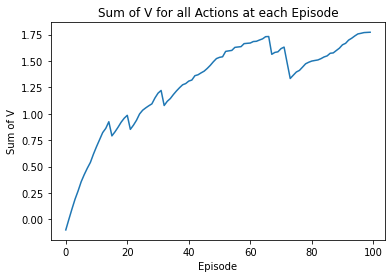

In [7]:
plt.plot(range(0,num_episodes), Mdl[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

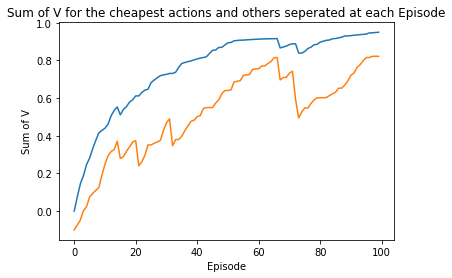

In [10]:
plt.plot(range(0,num_episodes), Mdl[1],range(0,num_episodes), Mdl[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

#### So why is this happening and why did the model suggest the actions it did?

To understand that, we need to disect the suggestions made by the model at each episode and how this relates to our return.

Below, we have taken the optimal action for each state. We can see that the suggested actions do vary greatly between episodes and the model appears to decide which is wants to suggest very quickly.

Therefore, I have plotted the total cost of the suggested actions at each episode and we can see the actions vary initially then smooth out and the resulting total cost is below our budget. This helps us understand what is going on greatly.

So far, all we have told the model is to provide a selection that is below budget and it has. It has simply found a answer that is below the budget as required.

So what is the next step? Before I introduce rewards I want to demonstrate what happens if I vary some of the parameters and what we can do if we decide to change what we want our model to suggest.

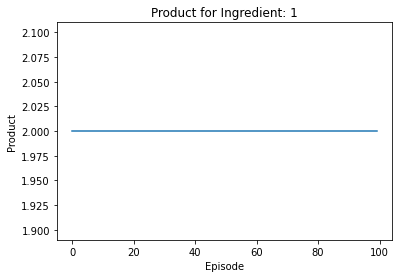

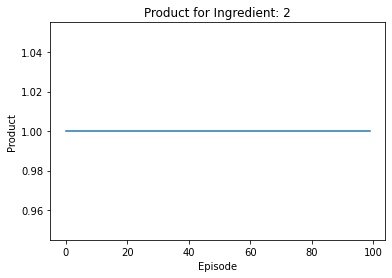

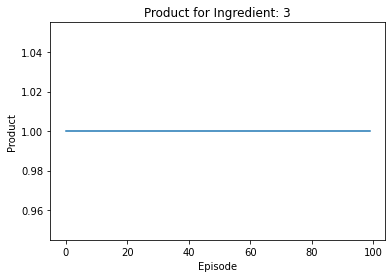

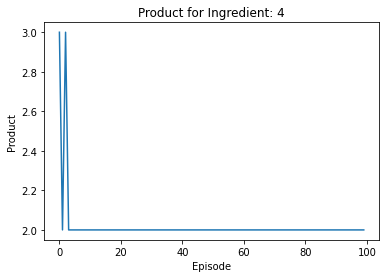

In [9]:
Ingredients = list(set(data['Ingredient']))
actions = pd.DataFrame()

for a in range(0, len(Ingredients)):   
    individualactions = []
    for i in range(0,num_episodes):    
        individualactions = np.append(individualactions, Mdl[5][a+(i*(len(Ingredients)))])
    actions[a] = individualactions
    plt.plot(range(0,num_episodes), actions[a])
    plt.title('Product for Ingredient: ' + str(a+1))
    plt.xlabel('Episode')
    plt.ylabel('Product')
    plt.show()    

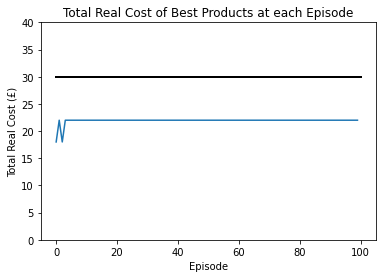

In [12]:
actions2 = actions
actions2['Product1'] = actions2.iloc[:,0]+10
actions2['Product2'] = actions2.iloc[:,1]+20
actions2['Product3'] = actions2.iloc[:,2]+30
actions2['Product4'] = actions2.iloc[:,3]+40

actions3 = actions2.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product1',right_on = 'QMerged_label', how = 'left')
actions4 = actions3.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product2',right_on = 'QMerged_label', how = 'left')
actions5 = actions4.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product3',right_on = 'QMerged_label', how = 'left')
actions6 = actions5.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product4',right_on = 'QMerged_label', how = 'left')


actions6['Total_Cost'] = actions6.iloc[:,9] + actions6.iloc[:,11] + actions6.iloc[:,13] + actions6.iloc[:,15]
actions6 = actions6.iloc[:,[0,1,2,3,-1]]

actions6 = actions6.iloc[:num_episodes]

plt.plot(range(0,num_episodes), actions6['Total_Cost'])
plt.plot([0, num_episodes], [budget, budget], 'k-', lw=2)
plt.title('Total Real Cost of Best Products at each Episode')
plt.xlabel('Episode')
plt.ylabel('Total Real Cost (£)')
plt.ylim([0,budget+10])
plt.show()

## Effect of Changing Parameters and How to Change Model's Aim

We have a few parameters that can be changed:

1. The Budget

2. Our learning rate, $\alpha$

3. Out action selection parameter, $\epsilon$


#### Varying Budget

First, lets observe what happens if we make our budget either impossibly low or high.

A budget that means we only obtain a negative reward means that we will force our V to converge negatively whereas a budget that is too high will cause our V to converge positively as all actions are continually positive.

The latter seems like what we had in our first run, a lot of the episodes lead to positive outcomes and so many combinations of products are possible and there is little distinction between the cheapest products from the rest.

If instead we consider a budget that is reasonably low given the prices of the products, we can see a trend where the cheapest products look to be converging positively and the more expensive products converging negatively. However, the smoothness of these is far from ideal, both appear to be oscillating greatly between each episode.

So what can we do the reduce the 'spikiness' of the outputs? This leades us onto our next parameter, alpha.

--- 1.6984620094299316 seconds ---


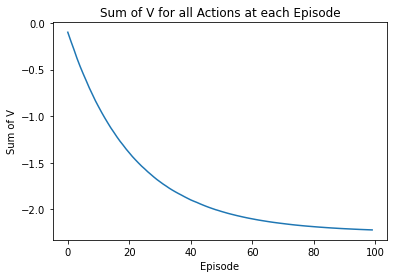

In [13]:
##### Make budget very small
budget2 = 5


alpha2 = 0.1
num_episodes2 = 100
epsilon2 = 0.5


# Currently not using a reward
reward2 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl2 = MCModelv1(data=data, alpha = alpha2, e = num_episodes2,epsilon = epsilon2, budget = budget2, reward = reward2)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,num_episodes2), Mdl2[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

--- 1.5173513889312744 seconds ---


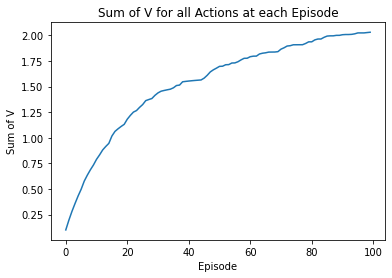

In [14]:
# Make budget very large
budget3 = 100


alpha3 = 0.1
num_episodes3 = 100
epsilon3 = 0.5


# Currently not using a reward
reward3 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl3 = MCModelv1(data=data, alpha = alpha3, e = num_episodes3,epsilon = epsilon3, budget = budget3, reward = reward3)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,num_episodes), Mdl3[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

--- 1.8773093223571777 seconds ---


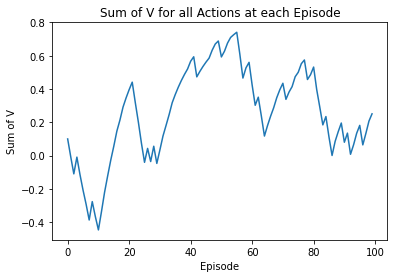

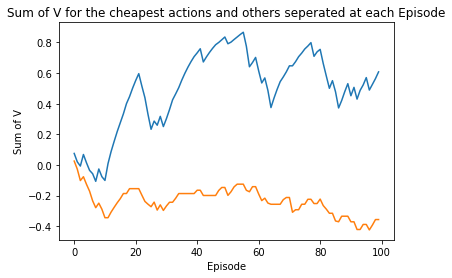

In [15]:
# Make budget reasonably small
budget4 = 23


alpha4 = 0.1
num_episodes4 = 100
epsilon4 = 0.5


# Currently not using a reward
reward4 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl4 = MCModelv1(data=data, alpha = alpha4, e = num_episodes4,epsilon = epsilon4, budget = budget4, reward = reward4)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,num_episodes4), Mdl4[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes4), Mdl4[1],range(0,num_episodes4), Mdl4[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

## Varying Alpha
#### A good explination of what is going on with our outupt due to alpha is described by stack overflow user VishalTheBeast:
    
"Learning rate tells the magnitude of step that is taken towards the solution.

It should not be too big a number as it may continuously oscillate around the minima and it should not be too small of a number else it will take a lot of time and iterations to reach the minima.

The reason why decay is advised in learning rate is because initially when we are at a totally random point in solution space we need to take big leaps towards the solution and later when we come close to it, we make small jumps and hence small improvements to finally reach the minima.

Analogy can be made as: in the game of golf when the ball is far away from the hole, the player hits it very hard to get as close as possible to the hole. Later when he reaches the flagged area, he choses a different stick to get accurate short shot.

So its not that he won't be able to put the ball in the hole without choosing the short shot stick, he may send the ball ahead of the target two or three times. But it would be best if he plays optimally and uses the right amount of power to reach the hole. Same is for decayed learning rate." 
    
    
https://stackoverflow.com/questions/33011825/learning-rate-of-a-q-learning-agent

To better demonstrate the effect of varying our alpha, I will be using an animated plot created using Plot.ly.

I have witten a more detailed guide on how to do this here:

https://www.philiposbornedata.com/2018/03/01/creating-interactive-animation-for-parameter-optimisation-using-plot-ly/

---

In our first animation, we vary alpha between 1 and 0.1. This enables us to see that as we reduce alpha our output smooths somewhat but it still pretty rough.

To investigate this further, I have then created a similar plot for alpha between 0.1 and 0.01. This emphasises the smoothing effect alpha has even more so.

However, even though the results are smoothing out, they are no longer converging in 100 episodes and, furthermore, they output seems to alternate between each alpha. This is due to a combination of small alphas requireing more episodes to learn and out action selection paramter epsilon being 0.5. Essentially, the output is still being decided by randomness half of the time and so out results are not converging within the 100 episode frame. 

In [16]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 5.0 MB/s eta 0:00:00


In [17]:
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, HTML
from chart_studio import plotly as py
init_notebook_mode(connected=True)

In [18]:
# Provide all parameters fixed except alpha
budget5 = 23
num_episodes5 = 100
epsilon5 = 0.5

# Currently not using a reward
reward5 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA = []    
lA = []
num_episodes5_2 = []
for x in range(0, 10):
    alpha5 = 1 - x/10
    Mdl5 = MCModelv1(data=data, alpha = alpha5, e = num_episodes5,epsilon = epsilon5, budget = budget5, reward = reward5)
    VforInteractiveGraphA = np.append(VforInteractiveGraphA, Mdl5[0])
    for y in range(0, num_episodes5):
        lA = np.append(lA,alpha5)
        num_episodes5_2 = np.append(num_episodes5_2, y)
VforInteractiveGraphA2 = pd.DataFrame(VforInteractiveGraphA,lA)
VforInteractiveGraphA2['index1'] = VforInteractiveGraphA2.index
VforInteractiveGraphA2['Episode'] = num_episodes5_2
VforInteractiveGraphA2.columns = ['V', 'Alpha', 'Episode']
VforInteractiveGraphA2 = VforInteractiveGraphA2[['Alpha','Episode', 'V']]

VforInteractiveGraphA2.head()

,Alpha,Episode,V
1.0,1.0,0.0,1.0
1.0,1.0,1.0,1.0
1.0,1.0,2.0,-0.5
1.0,1.0,3.0,-2.0
1.0,1.0,4.0,-2.0


In [19]:
VforInteractiveGraphA3 = VforInteractiveGraphA2
VforInteractiveGraphA3['continent'] = 'Test'
VforInteractiveGraphA3['country'] = 'Test2'
VforInteractiveGraphA3['pop'] = 7000000.0
VforInteractiveGraphA3.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

alphaforGraph = list(set(VforInteractiveGraphA3['year']))
alphaforGraph = np.round(alphaforGraph,1)
alphaforGraph = np.sort(alphaforGraph)[::-1]
years = np.round([(alphaforGraph) for alphaforGraph in alphaforGraph],1)
years

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

In [20]:
%matplotlib inline

dataset = VforInteractiveGraphA3

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Alpha: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop'])
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)

In [21]:
# Provide all parameters fixed except alpha
budget6 = 23
num_episodes6 = 100
epsilon6 = 0.5

# Currently not using a reward
reward6 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA_2 = []    
lA2 = []
num_episodes6_2 = []
for x in range(0, 10):
    alpha6 = 0.1 - x/100
    Mdl6 = MCModelv1(data=data, alpha = alpha6, e = num_episodes6,epsilon = epsilon6, budget = budget6, reward = reward6)
    VforInteractiveGraphA_2 = np.append(VforInteractiveGraphA_2, Mdl6[0])
    for y in range(0, num_episodes6):
        lA2 = np.append(lA2,alpha6)
        num_episodes6_2 = np.append(num_episodes6_2, y)
VforInteractiveGraphA_22 = pd.DataFrame(VforInteractiveGraphA_2,lA2)
VforInteractiveGraphA_22['index1'] = VforInteractiveGraphA_22.index
VforInteractiveGraphA_22['Episode'] = num_episodes6_2
VforInteractiveGraphA_22.columns = ['V', 'Alpha', 'Episode']
VforInteractiveGraphA_22 = VforInteractiveGraphA_22[['Alpha','Episode', 'V']]


VforInteractiveGraphA_23 = VforInteractiveGraphA_22
VforInteractiveGraphA_23['continent'] = 'Test'
VforInteractiveGraphA_23['country'] = 'Test2'
VforInteractiveGraphA_23['pop'] = 7000000.0
VforInteractiveGraphA_23.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

alphaforGraph2 = list(set(VforInteractiveGraphA_23['year']))
alphaforGraph2 = np.round(alphaforGraph2,2)
alphaforGraph2 = np.sort(alphaforGraph2)[::-1]
years = np.round([(alphaforGraph2) for alphaforGraph2 in alphaforGraph2],2)
years

%matplotlib inline

dataset = VforInteractiveGraphA_23

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Alpha: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],2) == np.round(year,2)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],2) == np.round(year,2)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop'])
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)

## Varying Epsilon
With the previous results in mind, we now fix alpha to be 0.05 and vary epsilone between 1 and 0 to show the effect of completely randomly selecting actions to selecting actions greedily.

We see that having a high epsilon creates very sporadic results. Therefore we should select something resonably small like 0.2. Although have epsilon equal to 0 looks good because of how smooth the curve is, as we mentioned earlier, this may lead us to a choice very quickly but may not be the best. We want some randomness so the model can explore other actions if needed.

In [22]:
# Provide all parameters fixed except alpha
budget7 = 23
num_episodes7 = 100
alpha7  = 0.05

# Currently not using a reward
reward7 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA_3 = []    
lA3 = []
num_episodes7_3 = []
for x in range(0, 11):
    epsilon7 = 1 - x/10
    Mdl7 = MCModelv1(data=data, alpha = alpha7, e = num_episodes7,epsilon = epsilon7, budget = budget7, reward = reward7)
    VforInteractiveGraphA_3 = np.append(VforInteractiveGraphA_3, Mdl7[0])
    for y in range(0, num_episodes7):
        lA3 = np.append(lA3,epsilon7)
        num_episodes7_3 = np.append(num_episodes7_3, y)
VforInteractiveGraphA_32 = pd.DataFrame(VforInteractiveGraphA_3,lA3)
VforInteractiveGraphA_32['index1'] = VforInteractiveGraphA_32.index
VforInteractiveGraphA_32['Episode'] = num_episodes7_3
VforInteractiveGraphA_32.columns = ['V', 'Epsilon', 'Episode']
VforInteractiveGraphA_32 = VforInteractiveGraphA_32[['Epsilon','Episode', 'V']]


VforInteractiveGraphA_33 = VforInteractiveGraphA_32
VforInteractiveGraphA_33['continent'] = 'Test'
VforInteractiveGraphA_33['country'] = 'Test2'
VforInteractiveGraphA_33['pop'] = 7000000.0
VforInteractiveGraphA_33.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

epsilonforGraph3 = list(set(VforInteractiveGraphA_33['year']))
epsilonforGraph3 = np.round(epsilonforGraph3,1)
epsilonforGraph3 = np.sort(epsilonforGraph3)[::-1]
years = np.round([(epsilonforGraph3) for epsilonforGraph3 in epsilonforGraph3],1)
years

%matplotlib inline

dataset = VforInteractiveGraphA_33

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Epsilon: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop']),
                'color': 'rgba(255, 182, 193, .9)'
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)

## Increasing the Number of Episodes

Lastly, we can increase the number of episodes. I refrained from doing this sooner because we were running 10 models in a loop to output our animated graphs and this would have caused the time taken to run the model to explode. 

We noted that a low alpha would require more episodes to learn so we can run our model for 1000 episodes.

However, we still notice that the output is oscillating, but, as mentioned before, this is due to our aim being simply to recommend a combination that is below budget. What this shows is that the model can't find the single best combination when there are many that fit below our budget.

Therefore, what happens if we change our aim slightly so that we can use the model to find the cheapest combination of products?

--- 18.02518916130066 seconds ---


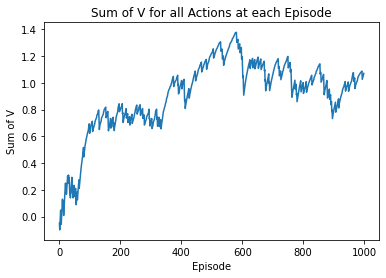

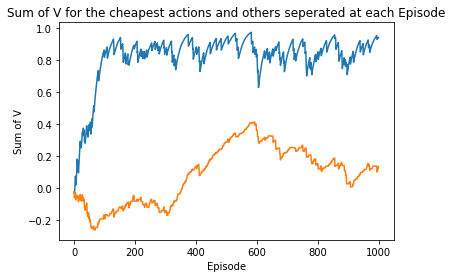

In [23]:
# Increase the number of episodes

budget8 = 23
alpha8 = 0.05
num_episodes8 = 1000
epsilon8 = 0.2

# Currently not using a reward
reward8 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl8 = MCModelv1(data=data, alpha = alpha8, e = num_episodes8,epsilon = epsilon8, budget = budget8, reward = reward8)

print("--- %s seconds ---" % (time.time() - start_time))


plt.plot(range(0,num_episodes8), Mdl8[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes8), Mdl8[1],range(0,num_episodes8), Mdl8[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

## Changing our Model's Aim to Find the Cheapest Combination of Products

#### This will now more clearly seperate the cheapest products from the rest and nearly always provides us with the cheapest combination of products.

To do this, all we need do is adapt our model slightly to provide a terminal reward that is relative to how far below or above budget this combination in the episode is. 

This can done by changing the calculation for return to:



        if(budget >= episode2['Real_Cost'].sum()):
            Return = (budget - episode2['Real_Cost'].sum())
        else:
            Return = (budget - episode2['Real_Cost'].sum())
            
We now see that the seperation between the cheapest products and the others is emphasised.

This really demonstrates the flexibility of reinforcement learning and how easy it can be to adapt the model based on your aims.

In [24]:
def MCModelv2(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = (budget - episode2['Real_Cost'].sum())  
        else:
            Return = (budget - episode2['Real_Cost'].sum())
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)

--- 19.161548376083374 seconds ---
Ingredient
1    2
2    1
3    1
4    3
Name: Product, dtype: int64


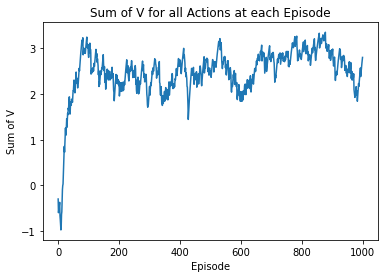

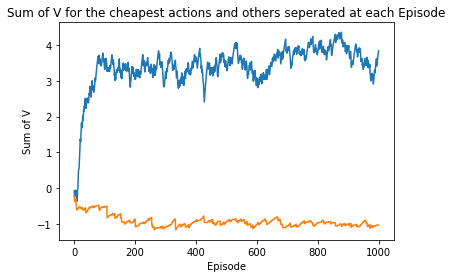

In [25]:
##### Make budget reasonably small
budget9 = 23


alpha9 = 0.05
num_episodes9 = 1000
epsilon9 = 0.2


# Currently not using a reward
reward9 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl9 = MCModelv2(data=data, alpha = alpha9, e = num_episodes9,epsilon = epsilon9, budget = budget9, reward = reward9)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl9[3])


plt.plot(range(0,num_episodes9), Mdl9[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes9), Mdl9[1],range(0,num_episodes9), Mdl9[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

# Introducing Preferences

So far, we have not included any personal preferences towards products. If we wanted to include this, we can simply introduce rewards for each product whilst still having a terminal reward that encourages the model to be below budget. 


This can done by changing the calculation for return to:



        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1 + (episode2['Reward'].sum())/len(Ingredients)
        else:
            Return = -1 + (episode2['Reward'].sum())/len(Ingredients)
            
So why is our return calculation now like this? 

Well firstly, we still want our combination to be below budget so we provide the positive and negative rewards for being above and below budget respectively.

Next, we want to account for the reward of each product. For our purposes, we define the rewards to be a value between 0 and 1. MC return is formally calculated using the following:


$$R =  \sum_{k=0}^{Num Actions} \gamma^{k-1} r_{k}  $$


$\gamma$ is the discount factor and this tells us how much we value later steps compared to earlier steps. In our case, all actions are equally as important to reaching the desired outcome of being below budget so we set $\gamma = 1$. 

However, to ensure that we reach the primary goal of being below budget, we take the average of the sum of the rewards for each action so that this will always be less than 1 or -1 respectively.

In [26]:
def MCModelv3(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1 + (episode2['Reward'].sum())/(len(Ingredients))
        else:
            Return = -1 + (episode2['Reward'].sum())/(len(Ingredients))
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)

## Introducing Preferences using Rewards

Say we decided we wanted product a1 and b2, we could add a reward to each. Let us see what happens if we do this in the output and graphs below. We have changed out budget slightly as a1 and b2 add up to £21 which means there is no way to select two more products that would put it below a budget of £23.

Applying a very high reward forces the modle to pick a1 and b2 then work around to find products that will put it under our budget.

I have kept in the comparison between the cheapest products and the rest to show that the model now is not valuing the cheapest once more. Instead we get the output a1, b2, c1 and d3 which has a total cost of £25. This is both below our budget and includes our preferred products.

--- 20.816078662872314 seconds ---
Ingredient
1    2
2    2
3    1
4    3
Name: Product, dtype: int64


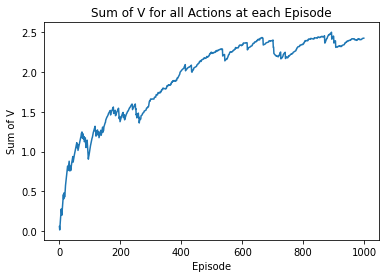

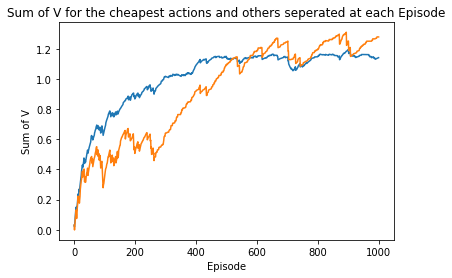

In [27]:
# Introduce simple rewards
budget10 = 30


alpha10 = 0.05
num_episodes10 = 1000
epsilon10 = 0.2


# Currently not using a reward
reward10 = [0.8,0,0,0.8,0,0,0,0,0]

start_time = time.time()

Mdl10 = MCModelv3(data=data, alpha = alpha10, e = num_episodes10,epsilon = epsilon10, budget = budget10, reward = reward10)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl10[3])


plt.plot(range(0,num_episodes10), Mdl10[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes10), Mdl10[1],range(0,num_episodes10), Mdl10[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

Let's try one more reward signal. This time, I give some reward to each but want it to provide the best combination from my rewards that still keeps us below budget.

We have the following rewards:

|Action|Reward|
|:----:|:----:|
|a1    | 0.8  |
|a2    | 0.4  |
|b1    | 0.5  |
|b2    | 0.6  |
|c1    | 0.4  |
|c2    | 0.4  |
|d1    | 0.6  |
|d2    | 0.2  |
|d3    | 0.4  |

Running this model a few times shows that it would:
- Often select a1 as this has a much higher reward
- Would always pick c1 as the rewards are the same but is cheaper
- Had a hard time selecting between b1 and b2 as the rewards are 0.5 and 0.6 but the costs are £8 and £11 respectively
- Would typically select d3 as being significantly cheaper than d1 even though reward is slightly less

--- 18.171306848526 seconds ---
Ingredient
1    2
2    1
3    1
4    3
Name: Product, dtype: int64


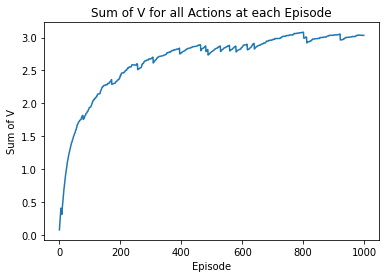

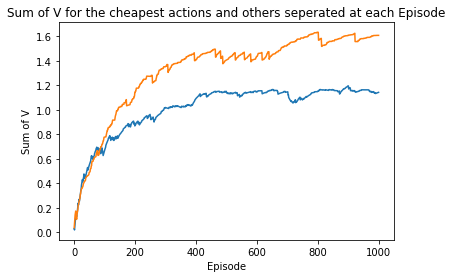

In [28]:
# Add rewards for more actions
budget11 = 30


alpha11 = 0.05
num_episodes11 = 1000
epsilon11 = 0.2


# Currently not using a reward
reward11 = [0.8,0.4,0.5,0.6,0.4,0.4,0.6,0.2,0.4]

start_time = time.time()

Mdl11 = MCModelv3(data=data, alpha = alpha11, e = num_episodes11,epsilon = epsilon11, budget = budget11, reward = reward11)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl11[3])


plt.plot(range(0,num_episodes11), Mdl11[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes11), Mdl10[1],range(0,num_episodes11), Mdl11[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

# Conclusion

We have managed to build a Monte Carlo Reinforcement Learning model to: 1) recommend products below a budget, 2) recommend the cheapest products and 3) recommened the best products based on a preference that is still below a budget.



Along the way, we have demonstrated the effect of changing parameters in reinforcement learning and how understanding these enables us to reach a desired result. 


There is much more that we could do, in my mind, the end goal would be to apply to a real recipe and products from a supermarket where the increased number of ingredients and products need to be accounted for.



I created this sample data and problem to better my understanding of Reinforcement Learning and hope that you find it useful.

Thanks

Philip Osborne